In [2]:
import pandas as pd
import os, sys
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

from utils import fcnn_models

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


## Data

In [3]:
def load_csv_data(file_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Reads the CSV with all the training data: grayscale log-mel spectrogram pixels, label and author of each sample
    And extracts them respectively, resizing the features to fit the CNN input shape (channel, height, width).

    Args:
        file_path (str): Path to the CSV file containing training data.

    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors from the CSV file. Features shape is (N x 70,112),
        while labels and authors are 1D arrays of size N, where N is the number of samples.
    """
    # Load training data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")

    # Extract labels, authors, and features
    labels = df['label'].values.astype(np.int64)
    authors = df['author'].values
    features = df.drop(columns=['label', 'author']).values.astype(np.float32)
    print(f"Features shape before reshape: {features.shape} (should be N x 70112!)")

    # Convert to 0-1 range
    features /= 255.0

    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Authors shape:", authors.shape)
    print("Unique classes:", len(np.unique(labels)))
    print("Unique authors:", len(np.unique(authors)))

    # No need for df variable after extracting features, release memory
    del df

    return features, labels, authors

Dataset shape: (2987, 70114)
Number of classes: 33
Number of authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 70112)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106


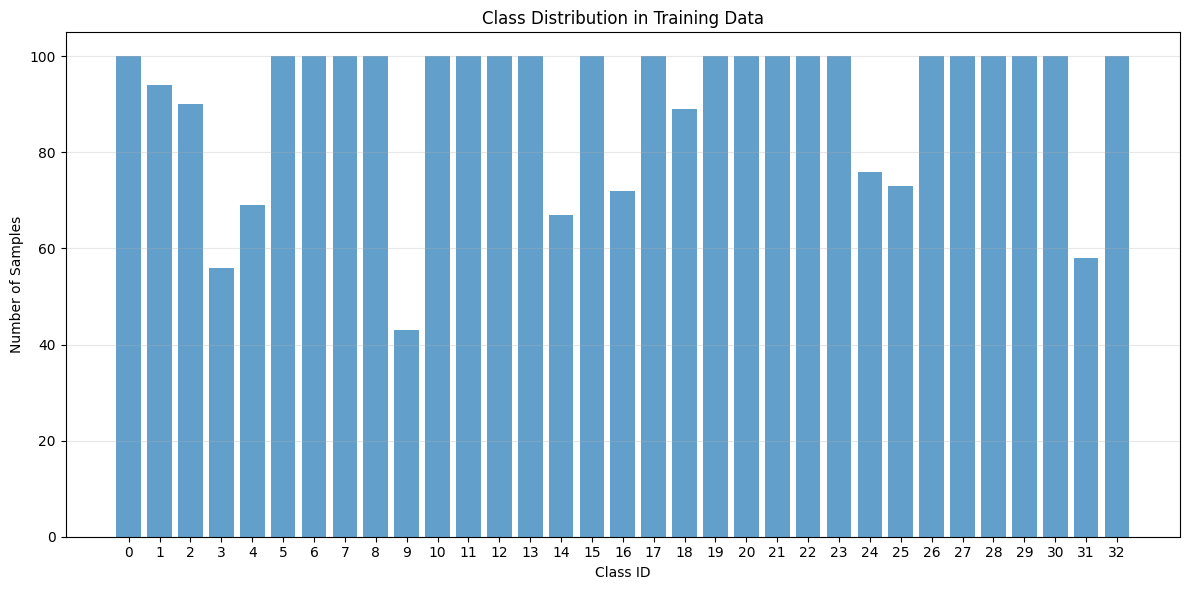

Average samples per class: 90.5


In [4]:
# Keep the old CSV-based loading for compatibility (uncomment if needed)
train_data_path = os.path.join('..', 'database', 'meta', 'final', 'train_data.csv')
features, labels, authors = load_csv_data(train_data_path)

# Display class distribution
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [5]:
# Split with a set seed, las que ya encontre arriba, para tardar menos
from utils.split import get_set_seed_indices, display_split_statistics
seed_single = 245323 # Quality: 0.2671

train_indices, val_indices, best_score, seed = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

# Extract train and validation data using indices
trFeatures = features[train_indices]
trLabels = labels[train_indices]
trAuthors = authors[train_indices]

vFeatures = features[val_indices]
vLabels = labels[val_indices]
vAuthors = authors[val_indices]

print(f"Training set: {trFeatures.shape[0]} samples")
print(f"Validation set: {vFeatures.shape[0]} samples")
print(f"Split quality score: {best_score}")

display_split_statistics((train_indices, val_indices, best_score, seed), "single")

# Convert labels to one-hot encoding for BirdFCNN_v0 model
num_classes = len(np.unique(labels))

Training set: 2330 samples
Validation set: 657 samples
Split quality score: 0.26713002574246597

📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2330
Validation samples: 657
Split ratio: 78.00% - 22.00%
Quality score: 0.2671
----------------------------------------


## Training

In [6]:
from utils.fcnn_models import BirdFCNN, BirdFCNN_v1
from utils.metrics import plot_full_metrics
import time
import torch

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# Final FCNN Models - Select the best performing models from different categories
final_models = {
    'fcnn1': BirdFCNN,  # Baseline model with SGD
    'fcnn2': BirdFCNN_v1,  # Residual-inspired with skip connections
}

# Initialize results database for all model combinations
building_results = {}
class_num = num_classes

print(f"Ready to train {len(final_models)} FCNN models")
print("Selected models:")
for key, model_class in final_models.items():
    print(f"  {key}: {model_class.__name__}")

Using device: cuda
Ready to train 2 FCNN models
Selected models:
  fcnn1: BirdFCNN
  fcnn2: BirdFCNN_v1


In [7]:
# === FINAL FCNN MODELS TRAINING ===
print("="*80)
print("TRAINING FINAL FCNN MODELS")
print("="*80)

for model_key, model_class in final_models.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_key}: {model_class.__name__}")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Initialize model
        model = model_class(num_classes=class_num, input_dim=trFeatures.shape[1])
        
        # Train model - each model handles its own configuration internally
        result = model.train_model(
            trainX=trFeatures,
            trainY=trLabels,
            valX=vFeatures,
            valY=vLabels
        )
        
        # Store result
        building_results[model_key] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'model_class': model_class,
            'model': model  # Store the trained model
        }
        
        print(f"✅ {model_key} completed successfully!")
        print(f"   Model: {model_class.__name__}")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {building_results[model_key]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_key} failed: {str(e)}")
        building_results[model_key] = {
            'status': 'failed',
            'error': str(e),
            'model_class': model_class
        }

print(f"\n{'='*60}")
print("FINAL FCNN MODELS TRAINING COMPLETED")
successful_models = sum(1 for result in building_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_models}/{len(final_models)}")
print(f"{'='*60}")

TRAINING FINAL FCNN MODELS

Training fcnn1: BirdFCNN
Epoch 1/200 - Train Loss: 3.3702 - Acc: 0.0987 - F1: 0.0609 - Val Loss: 3.4906 - Val Acc: 0.0350 - Val F1: 0.0196
Early stopping at epoch 23
✅ fcnn1 completed successfully!
   Model: BirdFCNN
   Best Val Acc: 0.1005
   Best Val F1: 0.0872
   Training time: 10.1s

Training fcnn2: BirdFCNN_v1
✅ fcnn2 completed successfully!
   Model: BirdFCNN_v1
   Best Val Acc: 0.1644
   Best Val F1: 0.1542
   Training time: 65.7s

FINAL FCNN MODELS TRAINING COMPLETED
Successful models: 2/2


## Results

PLOTTING TRAINING METRICS


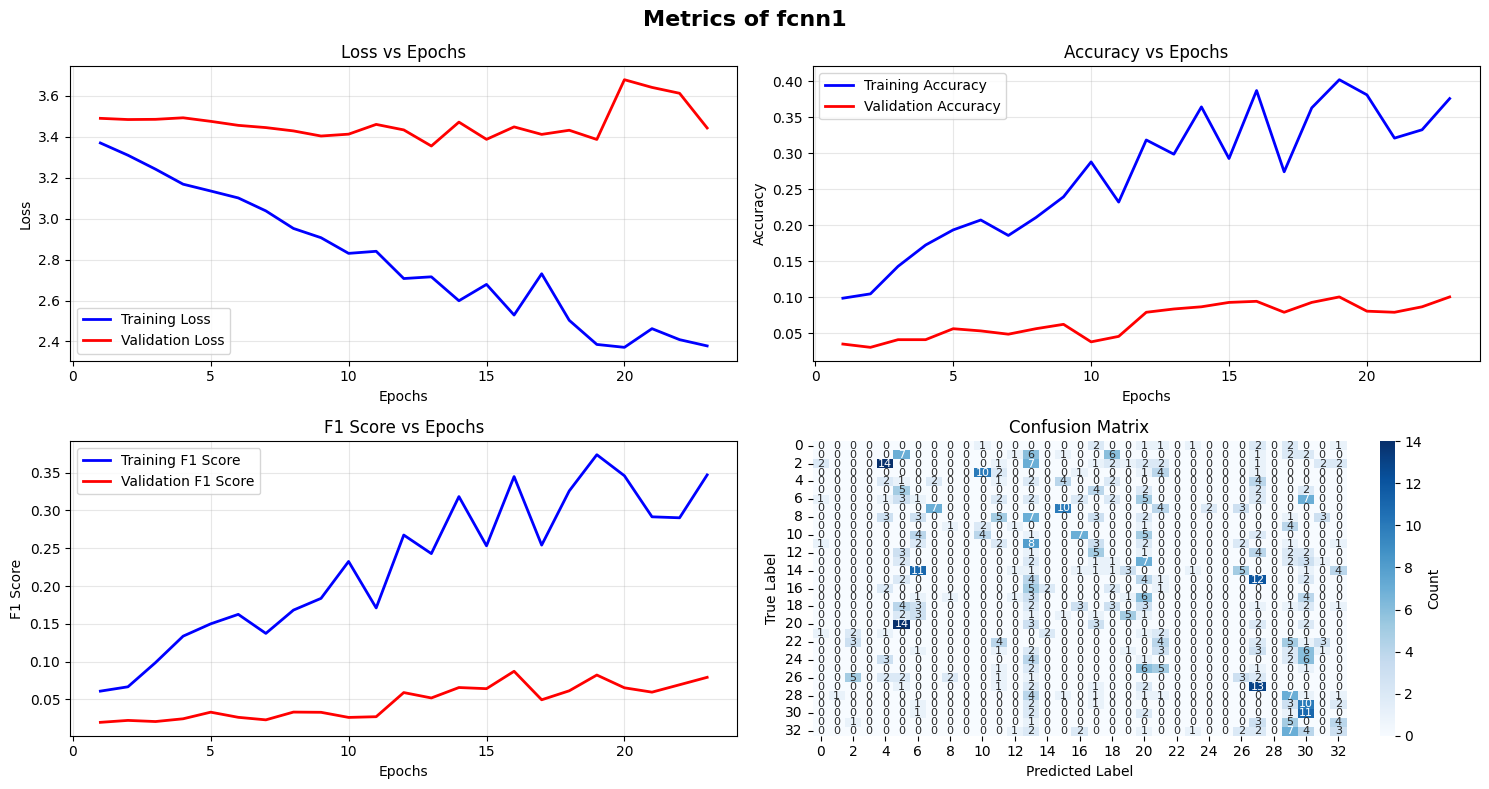

✅ Plotted metrics for fcnn1


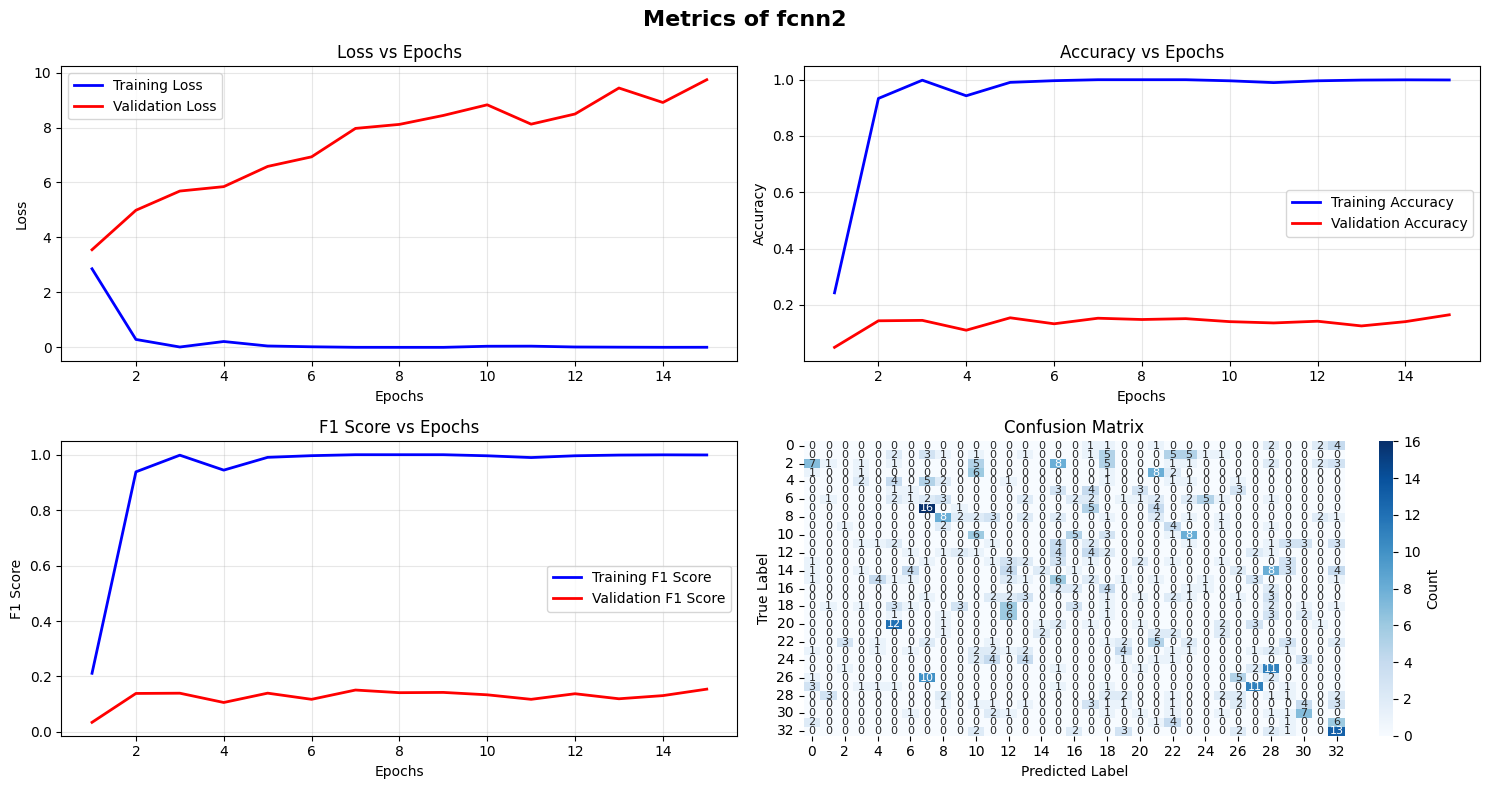

✅ Plotted metrics for fcnn2

Successfully plotted metrics for 2 FCNN models
BUILDING RESULTS TABLE
FCNN MODEL RESULTS TABLE (sorted by Best Val F1)
model architecture  best_val_acc  best_val_f1  training_time
fcnn2  BirdFCNN_v1        0.1644       0.1542        65.6666
fcnn1     BirdFCNN        0.1005       0.0872        10.0767

SUMMARY STATISTICS
Total successful runs: 2
Best F1 score: 0.1542 (fcnn2)
Best accuracy: 0.1644 (fcnn2)
Average F1 score: 0.1207
Average accuracy: 0.1324
Total training time: 1.3 minutes

TOP FCNN MODELS BY F1 SCORE:
model architecture  best_val_f1  best_val_acc
fcnn2  BirdFCNN_v1       0.1542        0.1644
fcnn1     BirdFCNN       0.0872        0.1005


In [8]:
# Results plotting - Training metrics for all successful models
print("="*80)
print("PLOTTING TRAINING METRICS")
print("="*80)

# Plot training metrics for all successful models
successful_results = []
for model_key, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        try:
            # Use plot_full_metrics with history and confusion matrix
            plot_full_metrics(
                config_id=model_key,
                history=result['history'],
                cm=result.get('confusion_matrix', None)
            )
            successful_results.append((model_key, result))
            print(f"✅ Plotted metrics for {model_key}")
        except Exception as e:
            print(f"❌ Failed to plot {model_key}: {str(e)}")

print(f"\nSuccessfully plotted metrics for {len(successful_results)} FCNN models")

# Create comprehensive results table
print("="*80)
print("BUILDING RESULTS TABLE")
print("="*80)

table_data = []
for model_key, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        
        table_data.append({
            'model': model_key,
            'architecture': data['model_class'].__name__,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0),
            'training_time': data.get('training_time', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
if table_data:
    results_table = pd.DataFrame(table_data)
    results_table = results_table.sort_values('best_val_f1', ascending=False)

    print("FCNN MODEL RESULTS TABLE (sorted by Best Val F1)")
    print("=" * 100)
    print(results_table.to_string(index=False, float_format='%.4f'))
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total successful runs: {len(results_table)}")
    print(f"Best F1 score: {results_table['best_val_f1'].max():.4f} ({results_table.loc[results_table['best_val_f1'].idxmax(), 'model']})")
    print(f"Best accuracy: {results_table['best_val_acc'].max():.4f} ({results_table.loc[results_table['best_val_acc'].idxmax(), 'model']})")
    print(f"Average F1 score: {results_table['best_val_f1'].mean():.4f}")
    print(f"Average accuracy: {results_table['best_val_acc'].mean():.4f}")
    print(f"Total training time: {results_table['training_time'].sum()/60:.1f} minutes")
    
    # Top models by F1
    print(f"\nTOP FCNN MODELS BY F1 SCORE:")
    top_models = results_table[['model', 'architecture', 'best_val_f1', 'best_val_acc']]
    print(top_models.to_string(index=False, float_format='%.4f'))
    
else:
    print("No successful results found to display.")

print("="*80)

## Model Saving

In [9]:
# Save trained FCNN models to .pth files
print("="*80)
print("SAVING FINAL FCNN MODELS")
print("="*80)

models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

saved_models = 0
for model_key, data in building_results.items():
    if data['status'] == 'success' and 'model' in data:
        try:
            # Get the trained model from results
            model = data['model']
            
            # Save the complete model (architecture + weights)
            model_path = os.path.join(models_dir, f'{model_key.lower()}.pth')
            torch.save(model, model_path)
            
            print(f"✅ Saved {model_key} to {model_path}")
            saved_models += 1
            
            # Also save just the state dict as backup
            state_dict_path = os.path.join(models_dir, f'{model_key.lower()}_state_dict.pth')
            torch.save(model.state_dict(), state_dict_path)
            
        except Exception as e:
            print(f"❌ Failed to save {model_key}: {str(e)}")

print(f"\n{'='*60}")
print(f"FCNN MODEL SAVING COMPLETED")
print(f"Successfully saved {saved_models} out of {len([k for k, v in building_results.items() if v['status'] == 'success'])} trained models")
print(f"Models saved to: {models_dir}")
print(f"{'='*60}")

# Display saved model information
print(f"\nSAVED FCNN MODEL FILES:")
for model_key in building_results.keys():
    if building_results[model_key]['status'] == 'success':
        model_path = os.path.join(models_dir, f'{model_key.lower()}.pth')
        if os.path.exists(model_path):
            file_size = os.path.getsize(model_path) / (1024*1024)  # Size in MB
            print(f"  {model_key.lower()}.pth ({file_size:.1f} MB)")

print(f"\nTo load a FCNN model later, use:")
print(f"model = torch.load('path/to/model.pth', weights_only=False)")

SAVING FINAL FCNN MODELS
✅ Saved fcnn1 to ..\models\fcnn1.pth
✅ Saved fcnn2 to ..\models\fcnn2.pth

FCNN MODEL SAVING COMPLETED
Successfully saved 2 out of 2 trained models
Models saved to: ..\models

SAVED FCNN MODEL FILES:
  fcnn1.pth (137.2 MB)
  fcnn2.pth (278.1 MB)

To load a FCNN model later, use:
model = torch.load('path/to/model.pth', weights_only=False)
